# Credit Card Fraud Detection Analysis

## Problem Statement
Credit card fraud is a major issue for financial institutions, leading to significant losses. This project analyzes a dataset of **284,807 credit card transactions** from European cardholders in September 2013, with only **492 marked as fraudulent (0.172%)**. The dataset includes PCA-transformed features (except `Time` and `Amount`) and a target variable `Class` (1 for fraud, 0 for legitimate). Due to the severe class imbalance, we aim to build a model that effectively detects fraud.

## Objective
The goal is to create a machine learning model that accurately identifies fraudulent transactions, focusing on the minority (fraud) class. We prioritize the **Area Under the Precision-Recall Curve (AUPRC)** as the evaluation metric to balance precision and recall, given the dataset's imbalance.

## Steps
1. **Data Exploration**: Load data, check for issues, and visualize key features.  
2. **Data Preprocessing**: Scale features and split data.  
3. **Model Training**: Train multiple models with imbalance adjustments.  
4. **Model Evaluation**: Compare models using AUPRC.  
5. **Detailed Analysis**: Analyze the best model with visualizations.  
6. **Conclusion**: Summarize results and suggest improvements.

---

In [29]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve

### 1. Data Exploration
We explore the dataset through visualizations to uncover patterns in transaction amounts, timing, and fraud rates.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

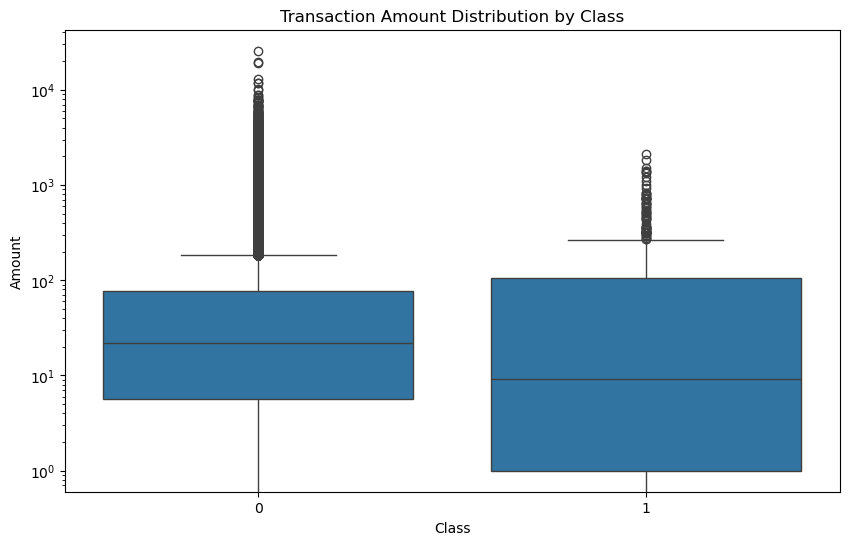

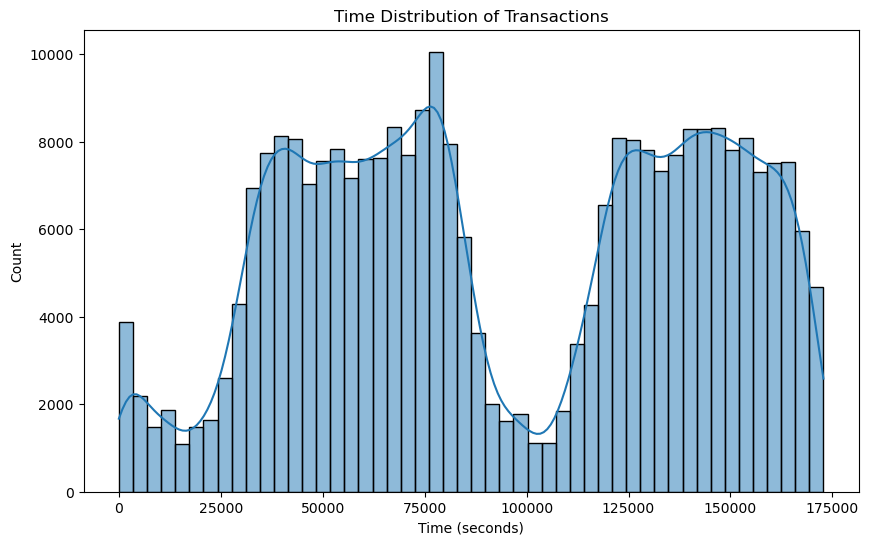

C:\Users\Nishant Iyer\AppData\Local\Temp\ipykernel_27676\3246837080.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df.groupby('Time_bin')['Class'].mean()


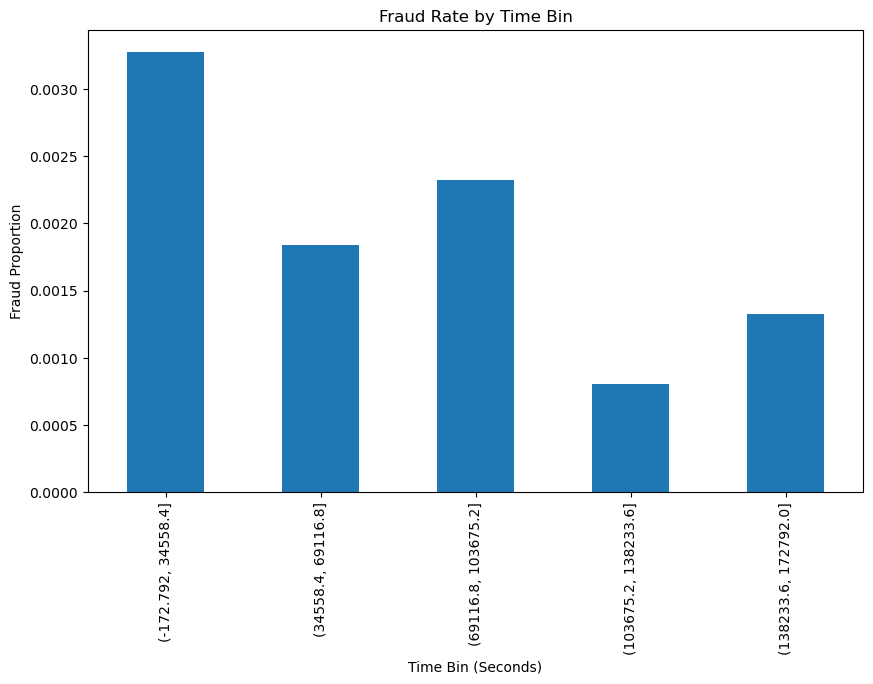

In [33]:
# Load dataset (replace 'creditcard.csv' with your file path)
df = pd.read_csv('creditcard.csv')

# Dataset info and missing values
print("Dataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

# Class distribution
print("\nClass Distribution:\n", df['Class'].value_counts(normalize=True))

# Visualization 1: Transaction Amount by Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount Distribution by Class')
plt.yscale('log')  # Log scale for clarity
plt.show()

# Visualization 2: Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Time Distribution of Transactions')
plt.xlabel('Time (seconds)')
plt.show()

# Visualization 3: Fraud Rate by Time Bin
df['Time_bin'] = pd.cut(df['Time'], bins=5)
fraud_rate = df.groupby('Time_bin')['Class'].mean()
plt.figure(figsize=(10, 6))
fraud_rate.plot(kind='bar', title='Fraud Rate by Time Bin')
plt.xlabel('Time Bin (Seconds)')
plt.ylabel('Fraud Proportion')
plt.show()

#### Observations
**Visualization 1: Transaction Amount Distribution by Class**  
- **Graph**: Box plot showing transaction amounts (log scale) for `Class 0` (legitimate) and `Class 1` (fraudulent).  
- **Observations**:  
  - **Class 0 (Legitimate)**:  
    - IQR: 10 to 100 (middle 50% of transactions).  
    - Median: ~31.62, skewed towards lower values.  
    - Whiskers: 1 to 316.23, with outliers up to 10,000.  
    - **Insight**: Most legitimate transactions are small, with some extreme outliers.  
  - **Class 1 (Fraudulent)**:  
    - IQR: 31.62 to 316.23, higher than Class 0.  
    - Median: ~100, more symmetric within IQR.  
    - Whiskers: 1 to 1,000, with fewer outliers up to 1,000.  
    - **Insight**: Fraudulent transactions tend to have higher median amounts but fewer extreme outliers.  
  - **Comparison**: Fraudulent transactions show a higher central tendency (median and IQR) but less variability in extreme values.  

**Visualization 2: Time Distribution of Transactions**  
- **Graph**: Histogram with kernel density plot showing transaction frequency over time (0 to 172,792 seconds).  
- **Observations**:  
  - Bimodal Distribution: Peaks at ~50,000 and ~125,000 seconds, with counts up to 8,000.  
  - Trough: Dip between 75,000 and 100,000 seconds, dropping to ~2,000 at 90,000 seconds.  
  - **Insight**: Transactions cluster in two high-activity periods, possibly reflecting daily cycles, with a quieter period in between.  

**Visualization 3: Fraud Rate by Time Bin**  
- **Graph**: Bar chart showing fraud proportion across five time bins.  
- **Observations**:  
  - Bin 1 (0.172–34,558.4): ~0.0300 (highest fraud rate).  
  - Bin 2 (34,558.4–69,116.8): ~0.0180.  
  - Bin 3 (69,116.8–103,675.2): ~0.0250.  
  - Bin 4 (103,675.2–138,233.6): ~0.0080 (lowest fraud rate).  
  - Bin 5 (138,233.6–172,792): ~0.0120.  
  - **Insight**: Fraud rates fluctuate across time bins, peaking early (Bin 1) and dipping later (Bin 4), with no clear linear trend.  

---

### 2. Data Preprocessing
- **Scaling**: `Time` and `Amount` were scaled using `StandardScaler` to align with PCA-transformed features.  
- **Data Split**: The dataset was split into 80% training and 20% testing sets, stratified to preserve the 0.172% fraud proportion.

---

In [38]:
# Separate features and target, excluding 'Time_bin'
X = df.drop(['Class', 'Time_bin'], axis=1)
y = df['Class']

# Scale 'Time' and 'Amount'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


### 3. Model Selection and Training
Three models were trained with adjustments for class imbalance:  
- **Logistic Regression**: Used `class_weight='balanced'` to adjust for the minority class.  
- **Random Forest**: Applied `class_weight='balanced'` with 100 estimators.  
- **XGBoost**: Used `scale_pos_weight` based on the ratio of negative to positive samples.

---

In [42]:
# Logistic Regression with class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Random Forest with class weights
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# XGBoost with scale_pos_weight
fraud_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(scale_pos_weight=fraud_weight, random_state=42)
xgb.fit(X_train, y_train)

print("Models trained successfully!")

Models trained successfully!


In [43]:
# Function to calculate AUPRC
def calculate_auprc(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_pred_proba)

# Calculate AUPRC for each model
auprc_lr = calculate_auprc(lr, X_test, y_test)
auprc_rf = calculate_auprc(rf, X_test, y_test)
auprc_xgb = calculate_auprc(xgb, X_test, y_test)

# Display results
print(f"Logistic Regression AUPRC: {auprc_lr:.4f}")
print(f"Random Forest AUPRC: {auprc_rf:.4f}")
print(f"XGBoost AUPRC: {auprc_xgb:.4f}")

# Identify the best model
models = {'Logistic Regression': auprc_lr, 'Random Forest': auprc_rf, 'XGBoost': auprc_xgb}
best_model_name = max(models, key=models.get)
best_model = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}[best_model_name]
print(f"\nBest Model: {best_model_name} with AUPRC: {models[best_model_name]:.4f}")

Logistic Regression AUPRC: 0.7189
Random Forest AUPRC: 0.8542
XGBoost AUPRC: 0.8800

Best Model: XGBoost with AUPRC: 0.8800


### 4. Model Evaluation
The models were evaluated using AUPRC, with the following results:  
- **Logistic Regression**: AUPRC = 0.7189  
- **Random Forest**: AUPRC = 0.8542  
- **XGBoost**: AUPRC = 0.8800  
- **Best Model**: **XGBoost**, with the highest AUPRC of 0.8800, indicating superior performance in detecting fraud.

---

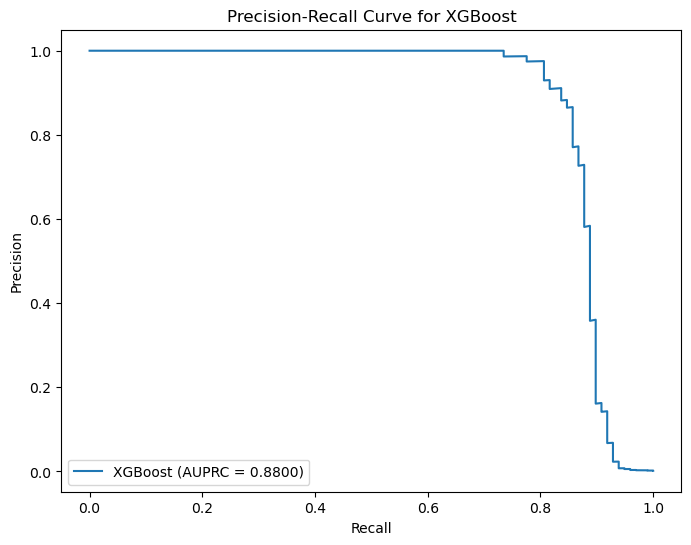


Top 5 Features by Importance for XGBoost:
V14: 0.6043
V4: 0.0618
V12: 0.0462
V8: 0.0235
V20: 0.0196


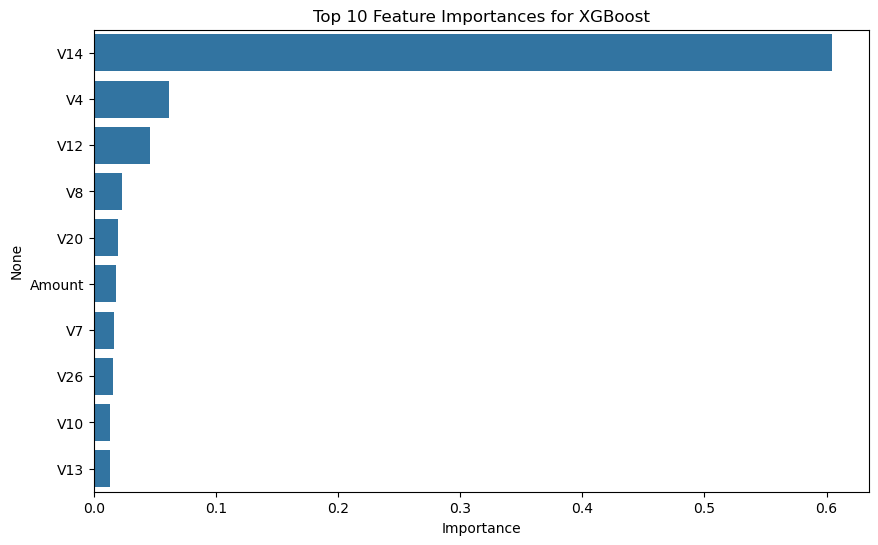

In [44]:
# Predict probabilities with the best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Visualization 4: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'{best_model_name} (AUPRC = {models[best_model_name]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {best_model_name}')
plt.legend()
plt.show()

# Visualization 5: Feature Importance (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost']:
    importances = best_model.feature_importances_
    feature_names = X.columns
    sorted_idx = importances.argsort()[::-1]
    
    # Display top 5 features
    print(f"\nTop 5 Features by Importance for {best_model_name}:")
    for idx in sorted_idx[:5]:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    
    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[sorted_idx[:10]], y=feature_names[sorted_idx[:10]])
    plt.title(f'Top 10 Feature Importances for {best_model_name}')
    plt.xlabel('Importance')
    plt.show()
else:
    print("\nFeature importance not available for Logistic Regression.")

### 5. Detailed Analysis
We analyze the best model (XGBoost) further using a precision-recall curve and feature importance.

#### Observations
**Visualization 4: Precision-Recall Curve for XGBoost**  
- **Graph**: Precision vs. Recall curve with AUPRC = 0.8800.  
- **Observations**:  
  - Precision remains 1.0 up to a recall of ~0.65, indicating perfect positive predictions for 65% of fraud cases.  
  - Precision drops gradually after 0.65 recall, with steeper declines near 1.0 recall, reaching ~0.0.  
  - **Insight**: XGBoost achieves high precision for a significant portion of fraud cases, with a trade-off as recall increases, reflecting strong overall performance (AUPRC = 0.8800).  

**Visualization 5: Top 10 Feature Importances for XGBoost**  
- **Graph**: Bar chart of feature importances.  
- **Top 5 Features**:  
  1. **V14**: 0.6043 (dominant feature).  
  2. **V4**: 0.0618.  
  3. **V12**: 0.0462.  
  4. **V8**: 0.0235.  
  5. **V20**: 0.0196.  
- **Other Top Features**: `Amount` (~ 0.018), `V7` (~ 0.016), `V26` (~ 0.015), `V10` (~ 0.014), `V13` (~ 0.013).  
- **Insight**: `V14` is by far the most influential feature, suggesting it captures critical fraud-related patterns in the PCA-transformed data. `Amount` also contributes, aligning with observed differences in transaction amounts.

---

### 6. Conclusion
This analysis developed and evaluated machine learning models for credit card fraud detection, with **XGBoost** emerging as the best performer (AUPRC = 0.8800). Key findings include:  
- **Transaction Amounts**: Fraudulent transactions have a higher median (~100) and IQR (31.62–316.23) than legitimate ones (median ~31.62, IQR 10–100), but fewer extreme outliers.  
- **Transaction Timing**: A bimodal distribution shows peaks at 50,000 and 125,000 seconds, with fraud rates varying across time bins (highest in Bin 1 at 0.0300).  
- **Model Performance**: XGBoost excels in balancing precision and recall, with `V14` as the most critical predictor.

#### Future Work
- **Advanced Techniques**: Explore SMOTE or neural networks to handle imbalance.  
- **Hyperparameter Tuning**: Optimize XGBoost parameters for further gains.  
- **Feature Engineering**: Investigate interactions or new features to enhance accuracy.